<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-makine-renmesi-lightgbm?scriptVersionId=126163916" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi ve Değişkenler

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün.
Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi.
MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı
Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Veri Setinin Keşfi

In [2]:
df_med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv', index_col='Tarih', parse_dates=True)
df_train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv' , index_col='Tarih', parse_dates=True)
df_test = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv', index_col='Tarih', parse_dates=True)
df_all = pd.concat([df_train, df_test], axis=0)
df_all.reset_index(inplace=True)

* df_train veri setinde 1673 günlük 24'er saatlikveri vardır.

     df_train veri seti 2018-01-01 00:00:00 tarihinden 2022-07-31 23:00:00 tarihine kadar veri içermektedir.

* df_test veri setinde 31 günlük 24'er saatlik veri vardır.
    
    df_test veri seti 2022-08-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 
    
* df_all veri setinde 1704 günlük 24'er saatlik veri vardır.
    
    df_all veri seti 2018-01-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 

    "Dağıtılan Enerji (MWh)" = 0 olanlar df_test 
    
    "Dağıtılan Enerji (MWh)" > 0 olanlar df_train

In [3]:
df_all.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [4]:
df_all.tail()

,Tarih,Dağıtılan Enerji (MWh)
40891,2022-08-31 19:00:00,0.0
40892,2022-08-31 20:00:00,0.0
40893,2022-08-31 21:00:00,0.0
40894,2022-08-31 22:00:00,0.0
40895,2022-08-31 23:00:00,0.0


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Dağıtılan Enerji (MWh),40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [7]:
check_df(df_train)

##################### Shape #####################
(40152, 1)
##################### Types #####################
Dağıtılan Enerji (MWh)    float64
dtype: object
##################### Head #####################
                     Dağıtılan Enerji (MWh)
Tarih                                      
2018-01-01 00:00:00             1593.944216
2018-01-01 01:00:00             1513.933887
2018-01-01 02:00:00             1402.612637
2018-01-01 03:00:00             1278.527266
2018-01-01 04:00:00             1220.697701
##################### Tail #####################
                     Dağıtılan Enerji (MWh)
Tarih                                      
2022-07-31 19:00:00             2492.489498
2022-07-31 20:00:00             2479.958245
2022-07-31 21:00:00             2485.016884
2022-07-31 22:00:00             2396.574255
2022-07-31 23:00:00             2285.252844
##################### NA #####################
Dağıtılan Enerji (MWh)    0
dtype: int64
##################### Quantiles #######

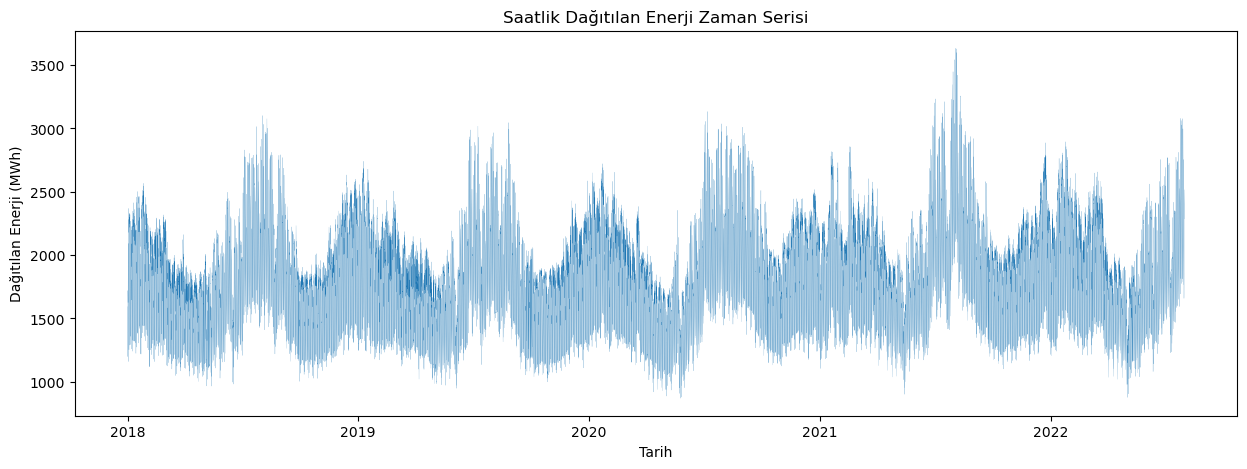

In [8]:
plt.figure(figsize=(15,5))
plt.title("Saatlik Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train["Dağıtılan Enerji (MWh)"],linewidth=0.1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

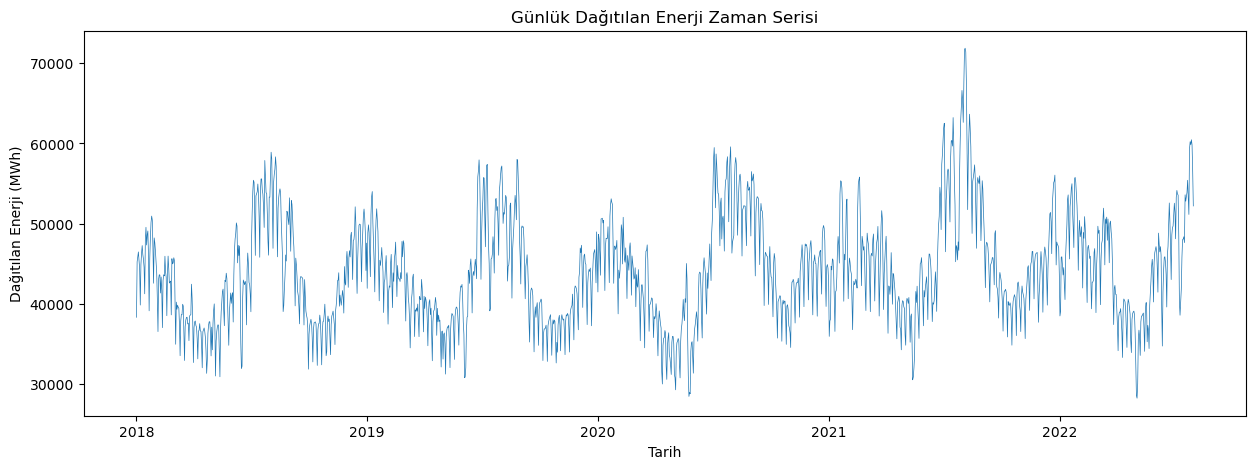

In [9]:
plt.figure(figsize=(15,5))
plt.title("Günlük Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('D').sum(),linewidth=0.5)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

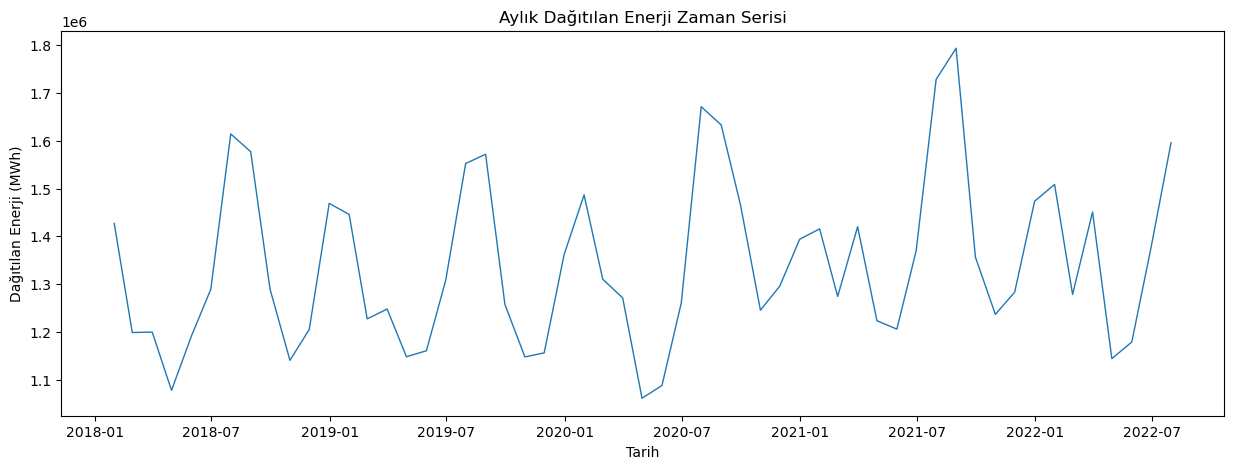

In [10]:
plt.figure(figsize=(15,5))
plt.title("Aylık Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('M').sum(),linewidth=1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

# Makine Öğrenmesi ile Çözüm

Veriler günlük ortalama değerlere çevirilip daha sonra saatlik Ağustos ayı dağılımlarına göre dağıtılacaktır.
2022 Ağustos ayı günleri tahmini için 2021 Ağustos ayı günleri değerleri validasyon verisi olarak alınacaktır.

In [11]:
train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv', parse_dates=['Tarih'])

In [12]:
train.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [13]:
train["Tarih"].min()

Timestamp('2018-01-01 00:00:00')

In [14]:
train["Tarih"].max()

Timestamp('2022-07-31 23:00:00')

In [15]:
def create_date_features(df, date_column):
    df['hour'] = df[date_column].dt.strftime("%H")
    df["hour"] = df["hour"].astype('int64')
    df['date'] = df[date_column].dt.strftime("%Y-%m-%d")
    df["date"] = pd.to_datetime(df["date"])
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df_all, "Tarih")
df.head()

,Tarih,Dağıtılan Enerji (MWh),hour,date,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01 00:00:00,1593.944216,0,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01 01:00:00,1513.933887,1,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01 02:00:00,1402.612637,2,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01 03:00:00,1278.527266,3,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01 04:00:00,1220.697701,4,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [16]:
df_med.head()

""
Tarih
2019-12-23
2019-06-12
2019-01-25
2019-09-25
2019-03-29


In [17]:
df["is_med"] = 0

In [18]:
df.loc[df["date"].isin(df_med.index), "is_med"] = 1

In [19]:
df["is_med"].sum()

720

In [20]:
df.head()

,Tarih,Dağıtılan Enerji (MWh),hour,date,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_med
0,2018-01-01 00:00:00,1593.944216,0,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
1,2018-01-01 01:00:00,1513.933887,1,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
2,2018-01-01 02:00:00,1402.612637,2,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
3,2018-01-01 03:00:00,1278.527266,3,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
4,2018-01-01 04:00:00,1220.697701,4,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40896 entries, 0 to 40895
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Tarih                   40896 non-null  datetime64[ns]
 1   Dağıtılan Enerji (MWh)  40896 non-null  float64       
 2   hour                    40896 non-null  int64         
 3   date                    40896 non-null  datetime64[ns]
 4   month                   40896 non-null  int64         
 5   day_of_month            40896 non-null  int64         
 6   day_of_year             40896 non-null  int64         
 7   week_of_year            40896 non-null  int64         
 8   day_of_week             40896 non-null  int64         
 9   year                    40896 non-null  int64         
 10  is_wknd                 40896 non-null  int64         
 11  is_month_start          40896 non-null  int64         
 12  is_month_end            40896 non-null  int64 

In [22]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [23]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['enerji_lag_' + str(lag)] = dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [24]:
df.iloc[40895-17520]

Tarih                     2020-08-31 23:00:00
Dağıtılan Enerji (MWh)            2311.715018
hour                                       23
date                      2020-08-31 00:00:00
month                                       8
day_of_month                               31
day_of_year                               244
week_of_year                               36
day_of_week                                 0
year                                     2020
is_wknd                                     0
is_month_start                              0
is_month_end                                1
quarter                                     3
is_quarter_start                            0
is_quarter_end                              0
is_year_start                               0
is_year_end                                 0
is_med                                      0
Name: 23375, dtype: object

In [25]:
df.iloc[40895-18264]

Tarih                     2020-07-31 23:00:00
Dağıtılan Enerji (MWh)            2046.497523
hour                                       23
date                      2020-07-31 00:00:00
month                                       7
day_of_month                               31
day_of_year                               213
week_of_year                               31
day_of_week                                 4
year                                     2020
is_wknd                                     1
is_month_start                              0
is_month_end                                1
quarter                                     3
is_quarter_start                            0
is_quarter_end                              0
is_year_start                               0
is_year_end                                 0
is_med                                      0
Name: 22631, dtype: object

In [26]:
# one_month_ago_test_hourly_lag = [i for i in range(0, 745)]

In [27]:
one_year_ago_test_hourly_lag = [i for i in range(8760, 9505)]

In [28]:
two_year_ago_test_hourly_lag  = [i for i in range(17520, 18265)]

In [29]:
# three_year_ago_test_hourly_lag  = [i for i in range(25560, 26305)]

In [30]:
# lag_list = one_month_ago_test_hourly_lag
lag_list = one_year_ago_test_hourly_lag
lag_list.extend(two_year_ago_test_hourly_lag)
# lag_list.extend(three_year_ago_test_hourly_lag)

In [31]:
df = lag_features(df, lag_list)

In [32]:
df.shape

(40896, 1509)

In [33]:
df.tail()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  \
40891 2022-08-31 19:00:00                     0.0    19 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2539.167006      2604.177598      2775.426507      2874.867106      2910.447877      2920.025731      2828.741217      2696.654755      2714.051847      2599.787032      2434.046470      2108.876628      1715.058569      1615.170813   
40892 2022-08-31 20:00:00                     0.0    20 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2572.293270      2540.285064      2607.745872      2770.497232      2876.713697      2909.286101      2917.808017      2827.707717      2696.681812      2715.405462      2604.179251      2434.053541      2108.012572      1713.686107   
40893 2022-08-31 21:00:00                     0.0    21 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2485.807097      2572.511624      2538.027324      2601.132845      2774.160352      2875.720159      2911.629195      2920.025451      2825.548282      2696.191937      2716.045402      2600.591133      2434.255992      2109.739586   
40894 2022-08-31 22:00:00                     0.0    22 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2348.484343      2486.259899      2573.054237      2539.117713      2604.245284      2771.693902      2875.447450      2911.491555      2920.114336      2830.039445      2701.874324      2715.139129      2598.454422      2434.981133   
40895 2022-08-31 23:00:00                     0.0    23 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2207.754575      2348.245480      2485.485694      2572.454327      2538.989164      2607.921641      2772.892008      2875.715187      2912.289188      2919.669334      2831.308171      2696.241417      2718.103995      2601.485414   

       enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  \
40891      1609.206264      1623.802261      1659.969077      1724.702280      1823.363902      1971.416736      2114.936125      2243.826646      2364.412531      2465.716662      2441.709355      2490.573138      2556.406771      2592.703743      2593.073454      2602.320964      2523.767409      2437.542045      2419.663137      2268.849410      2085.718684      1829.532226      1541.698773      1490.989009      1503.888424      1519.038430      1551.215913      1629.185596   
40892      1614.018857      1610.403358      1626.385412      1659.871744      1723.002504 

In [34]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['enerji_roll_mean_' + str(window)] = dataframe['Dağıtılan Enerji (MWh)'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=24, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [35]:
df = roll_mean_features(df, [8760, 17520])

In [36]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['enerji_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] =\
            dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [37]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [8760, 17520]

In [38]:
df = ewm_features(df, alphas, lags)
df.tail()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  \
40891 2022-08-31 19:00:00                     0.0    19 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2539.167006      2604.177598      2775.426507      2874.867106      2910.447877      2920.025731      2828.741217      2696.654755      2714.051847      2599.787032      2434.046470      2108.876628      1715.058569      1615.170813   
40892 2022-08-31 20:00:00                     0.0    20 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2572.293270      2540.285064      2607.745872      2770.497232      2876.713697      2909.286101      2917.808017      2827.707717      2696.681812      2715.405462      2604.179251      2434.053541      2108.012572      1713.686107   
40893 2022-08-31 21:00:00                     0.0    21 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2485.807097      2572.511624      2538.027324      2601.132845      2774.160352      2875.720159      2911.629195      2920.025451      2825.548282      2696.191937      2716.045402      2600.591133      2434.255992      2109.739586   
40894 2022-08-31 22:00:00                     0.0    22 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2348.484343      2486.259899      2573.054237      2539.117713      2604.245284      2771.693902      2875.447450      2911.491555      2920.114336      2830.039445      2701.874324      2715.139129      2598.454422      2434.981133   
40895 2022-08-31 23:00:00                     0.0    23 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2207.754575      2348.245480      2485.485694      2572.454327      2538.989164      2607.921641      2772.892008      2875.715187      2912.289188      2919.669334      2831.308171      2696.241417      2718.103995      2601.485414   

       enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  \
40891      1609.206264      1623.802261      1659.969077      1724.702280      1823.363902      1971.416736      2114.936125      2243.826646      2364.412531      2465.716662      2441.709355      2490.573138      2556.406771      2592.703743      2593.073454      2602.320964      2523.767409      2437.542045      2419.663137      2268.849410      2085.718684      1829.532226      1541.698773      1490.989009      1503.888424      1519.038430      1551.215913      1629.185596   
40892      1614.018857      1610.403358      1626.385412      1659.871744      1723.002504 

In [39]:
df = pd.get_dummies(df, columns=['hour','day_of_week', 'month'])

In [40]:
df['Dağıtılan Enerji (MWh)'] = np.log1p(df["Dağıtılan Enerji (MWh)"].values)

In [41]:
train = df.loc[(df["date"] < "2021-08-01"), :]

In [42]:
val = df.loc[(df["date"] >= "2021-08-01") & ((df["date"] < "2021-09-01")), :]

In [43]:
train.head()

,Tarih,Dağıtılan Enerji (MWh),date,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_med,enerji_lag_8760,enerji_lag_8761,enerji_lag_8762,enerji_lag_8763,enerji_lag_8764,enerji_lag_8765,enerji_lag_8766,enerji_lag_8767,enerji_lag_8768,enerji_lag_8769,enerji_lag_8770,enerji_lag_8771,enerji_lag_8772,enerji_lag_8773,enerji_lag_8774,enerji_lag_8775,enerji_lag_8776,enerji_lag_8777,enerji_lag_8778,enerji_lag_8779,enerji_lag_8780,enerji_lag_8781,enerji_lag_8782,enerji_lag_8783,enerji_lag_8784,enerji_lag_8785,enerji_lag_8786,enerji_lag_8787,enerji_lag_8788,enerji_lag_8789,enerji_lag_8790,enerji_lag_8791,enerji_lag_8792,enerji_lag_8793,enerji_lag_8794,enerji_lag_8795,enerji_lag_8796,enerji_lag_8797,enerji_lag_8798,enerji_lag_8799,enerji_lag_8800,enerji_lag_8801,enerji_lag_8802,enerji_lag_8803,enerji_lag_8804,enerji_lag_8805,enerji_lag_8806,enerji_lag_8807,enerji_lag_8808,enerji_lag_8809,enerji_lag_8810,enerji_lag_8811,enerji_lag_8812,enerji_lag_8813,enerji_lag_8814,enerji_lag_8815,enerji_lag_8816,enerji_lag_8817,enerji_lag_8818,enerji_lag_8819,enerji_lag_8820,enerji_lag_8821,enerji_lag_8822,enerji_lag_8823,enerji_lag_8824,enerji_lag_8825,enerji_lag_8826,enerji_lag_8827,enerji_lag_8828,enerji_lag_8829,enerji_lag_8830,enerji_lag_8831,enerji_lag_8832,enerji_lag_8833,enerji_lag_8834,enerji_lag_8835,enerji_lag_8836,enerji_lag_8837,enerji_lag_8838,enerji_lag_8839,enerji_lag_8840,enerji_lag_8841,enerji_lag_8842,enerji_lag_8843,enerji_lag_8844,enerji_lag_8845,enerji_lag_8846,enerji_lag_8847,enerji_lag_8848,enerji_lag_8849,enerji_lag_8850,enerji_lag_8851,enerji_lag_8852,enerji_lag_8853,enerji_lag_8854,enerji_lag_8855,enerji_lag_8856,enerji_lag_8857,enerji_lag_8858,enerji_lag_8859,enerji_lag_8860,enerji_lag_8861,enerji_lag_8862,enerji_lag_8863,enerji_lag_8864,enerji_lag_8865,enerji_lag_8866,enerji_lag_8867,enerji_lag_8868,enerji_lag_8869,enerji_lag_8870,enerji_lag_8871,enerji_lag_8872,enerji_lag_8873,enerji_lag_8874,enerji_lag_8875,enerji_lag_8876,enerji_lag_8877,enerji_lag_8878,enerji_lag_8879,enerji_lag_8880,enerji_lag_8881,enerji_lag_8882,enerji_lag_8883,enerji_lag_8884,enerji_lag_8885,enerji_lag_8886,enerji_lag_8887,enerji_lag_8888,enerji_lag_8889,enerji_lag_8890,enerji_lag_8891,enerji_lag_8892,enerji_lag_8893,enerji_lag_8894,enerji_lag_8895,enerji_lag_8896,enerji_lag_8897,enerji_lag_8898,enerji_lag_8899,enerji_lag_8900,enerji_lag_8901,enerji_lag_8902,enerji_lag_8903,enerji_lag_8904,enerji_lag_8905,enerji_lag_8906,enerji_lag_8907,enerji_lag_8908,enerji_lag_8909,enerji_lag_8910,enerji_lag_8911,enerji_lag_8912,enerji_lag_8913,enerji_lag_8914,enerji_lag_8915,enerji_lag_8916,enerji_lag_8917,enerji_lag_8918,enerji_lag_8919,enerji_lag_8920,enerji_lag_8921,enerji_lag_8922,enerji_lag_8923,enerji_lag_8924,enerji_lag_8925,enerji_lag_8926,enerji_lag_8927,enerji_lag_8928,enerji_lag_8929,enerji_lag_8930,enerji_lag_8931,enerji_lag_8932,enerji_lag_8933,enerji_lag_8934,enerji_lag_8935,enerji_lag_8936,enerji_lag_8937,enerji_lag_8938,enerji_lag_8939,enerji_lag_8940,enerji_lag_8941,enerji_lag_8942,enerji_lag_8943,enerji_lag_8944,enerji_lag_8945,enerji_lag_8946,enerji_lag_8947,enerji_lag_8948,enerji_lag_8949,enerji_lag_8950,enerji_lag_8951,enerji_lag_8952,enerji_lag_8953,enerji_lag_8954,enerji_lag_8955,enerji_lag_8956,enerji_lag_8957,enerji_lag_8958,enerji_lag_8959,enerji_lag_8960,enerji_lag_8961,enerji_lag_8962,enerji_lag_8963,enerji_lag_8964,enerji_lag_8965,enerji_lag_8966,enerji_lag_8967,enerji_lag_8968,enerji_lag_8969,enerji_lag_8970,enerji_lag_8971,enerji_lag_8972,enerji_lag_8973,enerji_lag_8974,enerji_lag_8975,enerji_lag_8976,enerji_lag_8977,enerji_lag_8978,enerji_lag_8979,enerji_lag_8980,enerji_lag_8981,enerji_lag_8982,enerji_lag_8983,enerji_lag_8984,enerji_lag_8985,enerji_lag_8986,enerji_lag_8987,enerji_lag_8988,enerji_lag_8989,enerji_lag_8990,enerji_lag_8991,enerji_lag_8992,enerji_lag_8993,enerji_lag_8994,enerji_lag_8995,enerji_lag_8996,enerji_lag_8997,enerj

In [44]:
cols = [col for col in train.columns if col not in ['Tarih', 'date', "Dağıtılan Enerji (MWh)", "year" ]]

In [45]:
Y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]

In [46]:
Y_val = val['Dağıtılan Enerji (MWh)']
X_val = val[cols]

In [47]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((31392,), (31392, 1557), (744,), (744, 1557))

In [48]:
lgb_params = {'metric': {'mape'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}


In [49]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [50]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.830865 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's mape: 0.0127271	valid_1's mape: 0.01572
[200]	training's mape: 0.0100237	valid_1's mape: 0.0119015
[300]	training's mape: 0.00873571	valid_1's mape: 0.0108547
[400]	training's mape: 0.00792739	valid_1's mape: 0.0106816
[500]	training's mape: 0.00739453	valid_1's mape: 0.0105579
[600]	training's mape: 0.00700098	valid_1's mape: 0.0104654
[700]	training's mape: 0.00669754	valid_1's mape: 0.0104795
Early stopping, best iteration is:
[595]	training's mape: 0.0070181	valid_1's mape: 0.0104569


In [51]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [52]:
mean_absolute_percentage_error(np.expm1(y_pred_val), np.expm1(Y_val))

0.08736189786066192

In [53]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
     'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

                    feature  split       gain
156         enerji_lag_8904    182  36.443252
324         enerji_lag_9072     68  11.438346
492         enerji_lag_9240     88   4.858346
1502  enerji_roll_mean_8760    334   4.371653
1               day_of_year    429   3.022072
...                     ...    ...        ...
1361       enerji_lag_18124      1   0.014147
78          enerji_lag_8826      7   0.014114
283         enerji_lag_9031      4   0.014051
589         enerji_lag_9337      5   0.014019
806        enerji_lag_17569      1   0.014009

[200 rows x 3 columns]


,feature,split,gain
156,enerji_lag_8904,182,36.443252
324,enerji_lag_9072,68,11.438346
492,enerji_lag_9240,88,4.858346
1502,enerji_roll_mean_8760,334,4.371653
1,day_of_year,429,3.022072
...,...,...,...
68,enerji_lag_8816,0,0.000000
278,enerji_lag_9026,0,0.000000
842,enerji_lag_17605,0,0.000000
843,enerji_lag_17606,0,0.000000


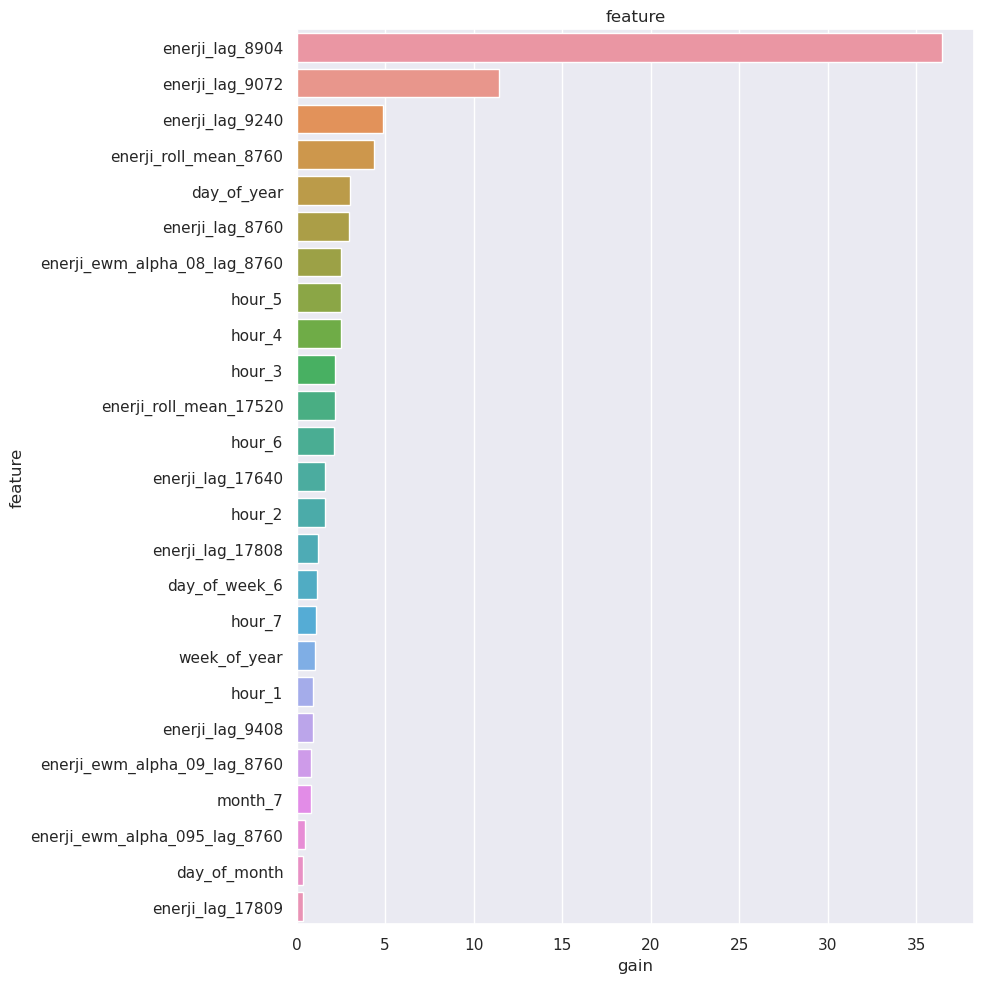

                    feature  split       gain
156         enerji_lag_8904    182  36.443252
324         enerji_lag_9072     68  11.438346
492         enerji_lag_9240     88   4.858346
1502  enerji_roll_mean_8760    334   4.371653
1               day_of_year    429   3.022072
...                     ...    ...        ...
1361       enerji_lag_18124      1   0.014147
78          enerji_lag_8826      7   0.014114
283         enerji_lag_9031      4   0.014051
589         enerji_lag_9337      5   0.014019
806        enerji_lag_17569      1   0.014009

[200 rows x 3 columns]


528

In [54]:
plot_lgb_importances(model, num=30, plot=True)

feat_imp = plot_lgb_importances(model, num=200)

# önem seviyesine göre gain değerleri 0 olanlar seçilip modelden çıkartılması
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [55]:
train = df.loc[~(df['Dağıtılan Enerji (MWh)'] == 0)]
Y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]
test = df.loc[df['Dağıtılan Enerji (MWh)'] == 0]
X_test = test[cols]

In [56]:
X_test.head()

day_of_month  day_of_year  week_of_year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  \
40152             1          213            31        0               1             0        3                 0               0              0            0       0      2570.612499      2724.204644      2844.420475      2964.729818      2997.777606      3053.683692      3125.775803      3179.600696      3202.461452      3210.887171      3226.875188      3164.075574      3068.563501      3012.251480      2862.756630      2654.048558      2350.046952      2050.300726      1971.398701   
40153             1          213            31        0               1             0        3                 0               0              0            0       0      2423.508580      2572.026293      2725.368999      2843.654371      2960.527412      3001.107749      3047.203894      3123.051326      3177.878818      3201.178274      3212.882678      3224.702714      3165.721304      3065.377325      3012.511432      2863.524271      2650.606186      2350.734168      2049.779423   
40154             1          213            31        0               1             0        3                 0               0              0            0       0      2285.460365      2421.269078      2570.784678      2723.460083      2844.724849      2958.152807      3001.114986      3048.841818      3123.244718      3177.839718      3202.356134      3209.856416      3224.492758      3165.737457      3065.459145      3015.361463      2860.850484      2652.209912      2348.928646   
40155             1          213            31        0               1             0        3                 0               0              0            0       0      2171.786371      2285.282120      2421.503282      2574.184151      2723.470436      2843.137642      2959.762296      2998.582913      3048.407432      3120.689817      3177.542800      3201.491052      3210.437342      3227.229971      3168.169977      3066.942389      3009.804287      2859.252029      2649.837862   
40156             1          213            31        0               1             0        3                 0               0              0            0       0      2083.471584      2173.973236      2286.741224      2424.748969      2572.944105      2725.917469      2843.981694      2962.698026      2998.605979      3046.297267      3121.781884      3176.626245      3201.593939      3210.730930      3223.982318      3167.051612      3066.841967      3011.347100      2860.934308   

       enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  enerji_lag_8802  enerji_lag_8803  enerji_lag_8804  enerji_lag_8805  enerji_lag_8806  \
40152      2067.775235      2114.023233      2177.055011      2289.548003      2444.167058      2607.153182      2801.449368      2942.096879      3045.771146      3047.907311      3058.881847      3166.987680      3338.458790      3423.676447      3448.570178      3404.387092      3268.477140      3176.141706      3127.979004      2975.094357      2771.632587      2462.396142      2045.086118      1921.039188      1993.627915      2031.345647      2103.355917      2185.293680   
40153      1968.713980      2063.417847      2118.625943      2174.766549      2292.967480

In [57]:
Y_train.shape, X_train.shape, X_test.shape

((40152,), (40152, 1557), (744, 1557))

In [58]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.096842 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [59]:
df_test["Dağıtılan Enerji (MWh)"] = np.expm1(test_preds)

In [60]:
df_test.head()

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2266.905249
2022-08-01 01:00:00,2145.543212
2022-08-01 02:00:00,1985.787168
2022-08-01 03:00:00,1920.008820
2022-08-01 04:00:00,1913.386365


In [61]:
df_test.to_csv("submission.csv")

[542]	training's mape: 0.00717928	valid_1's mape: 0.0106979 Tersine logaritma alınarak 0.08989344920202877 ve submission 6.89243